In [1]:
# --- SETUP ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')


# Cargar archivo .env
# Ruta relativa desde el notebook hasta el .env
dotenv_path = '../generadores/.env'  #

# Cargar el archivo .env desde la ruta especificada
load_dotenv(dotenv_path=dotenv_path)

# Leer variables de entorno
username = os.getenv("USUARIO_DB")
password = os.getenv("CLAVE_BD")

# Validar que se cargaron bien
#print("Usuario:", username)
#print("Contraseña cargada:", bool(password))  # No imprime la clave, pero verifica si existe

if not username or not password:
    raise ValueError("Las variables de entorno USUARIO_DB o CLAVE_BD no están definidas")

# Cadena de conexión
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=upgradeserver-vf.database.windows.net;'
    'DATABASE=Banco;'
    f'UID={username};'
    f'PWD={password};'
    'Connection Timeout=30;'
)

# Conexión
conn = pyodbc.connect(conn_str)



In [3]:
usuarios = pd.read_sql_query("SELECT * FROM usuarios", conn)
creditos = pd.read_sql_query("SELECT * FROM creditos", conn)
activos_financieros = pd.read_sql_query("SELECT usuario_id, tipo_activo, monto FROM activos_financieros", conn)


In [4]:
print(usuarios.columns)
print(creditos.columns)
print(activos_financieros.columns)


Index(['id', 'nombre', 'apellido', 'estado_civil', 'dni', 'nacionalidad',
       'fecha_nacimiento', 'direccion', 'codigo_postal', 'provincia',
       'telefono', 'email', 'es_moroso', 'profesion', 'salario',
       'numero_cuenta', 'tipo_cuenta', 'saldo', 'antiguedad_cliente',
       'genero'],
      dtype='object')
Index(['id', 'usuario_id', 'monto', 'fecha_inicio', 'fecha_fin', 'estado',
       'tipo'],
      dtype='object')
Index(['usuario_id', 'tipo_activo', 'monto'], dtype='object')


In [7]:
# Renombrar columna id a usuario_id en usuarios
usuarios = usuarios.rename(columns={'id': 'usuario_id'})

# Agrupar créditos por usuario
usuarios_creditos = creditos.groupby('usuario_id').size().reset_index(name='cantidad_creditos')

# Unir usuarios con créditos
usuarios_df = usuarios.merge(
    usuarios_creditos, 
    on='usuario_id', 
    how='left'
)

# Sumar monto total activos financieros por usuario
activos_totales = activos_financieros.groupby('usuario_id')['monto'].sum().reset_index(name='valor_activos')

# Unir con activos financieros
usuarios_df = usuarios_df.merge(
    activos_totales, 
    on='usuario_id', 
    how='left'
)

print(usuarios_df.head())


   usuario_id    nombre apellido estado_civil        dni nacionalidad  \
0           1     Isaac      Bas      Soltero  50803891L    Andorrana   
1           2  Sandalio  Fuentes   Divorciado  86252814P      Noruega   
2           3    Dorita   Tejera      Soltera  89546650Z    Argentina   
3           4     Mario    Lopez      Soltera  79407181A      Armenia   
4           5   Luciano   Osorio   Divorciado  11417891R       Croata   

  fecha_nacimiento                                          direccion  \
0       1976-08-03           Acceso de Lupe Alegre 4, Albacete, 49375   
1       1978-05-08  Cuesta de Teófilo Somoza 3 Puerta 8 , Huelva, ...   
2       1962-01-16  Camino de Danilo Roldan 54 Puerta 7 , La Coruñ...   
3       1958-02-09  Acceso Cebrián Balaguer 75 Piso 0 , Pontevedra...   
4       1987-02-23  Calle de Obdulia Múñiz 89 Piso 1 , Almería, 37332   

  codigo_postal provincia  ... es_moroso  \
0         04461  Zaragoza  ...     False   
1         05617     Soria  ...    

In [9]:
# Limpieza
usuarios_df['cantidad_creditos'] = usuarios_df['cantidad_creditos'].fillna(0)
usuarios_df['valor_activos'] = usuarios_df['valor_activos'].fillna(0)
usuarios_df[['provincia', 'estado_civil', 'profesion', 'nacionalidad']] = usuarios_df[
    ['provincia', 'estado_civil', 'profesion', 'nacionalidad']].fillna("Desconocido")


In [12]:
# --- ENCODING & SCALING ---
from datetime import datetime

# Convertir a datetime si no lo está
usuarios_df['fecha_nacimiento'] = pd.to_datetime(usuarios_df['fecha_nacimiento'], errors='coerce')

# Calcular edad en años
hoy = pd.Timestamp('today')
usuarios_df['edad'] = (hoy - usuarios_df['fecha_nacimiento']).dt.days // 365

from sklearn.preprocessing import LabelEncoder, StandardScaler

cat_vars = ['provincia', 'estado_civil', 'profesion', 'nacionalidad']
for col in cat_vars:
    le = LabelEncoder()
    usuarios_df[col] = le.fit_transform(usuarios_df[col].astype(str))  # por si hay NaNs

features = ['edad', 'salario', 'provincia', 'estado_civil', 'profesion', 'cantidad_creditos', 'valor_activos']

X_scaled = StandardScaler().fit_transform(usuarios_df[features])


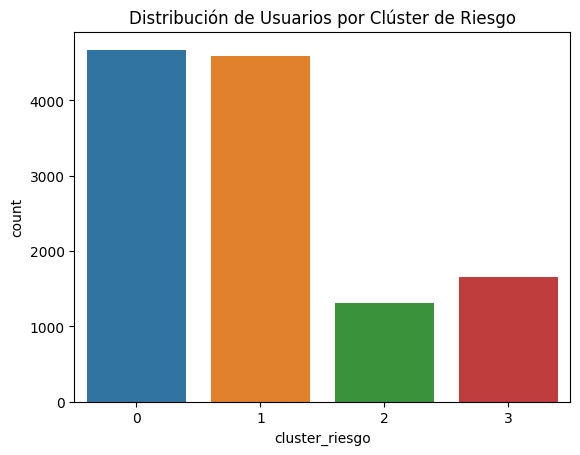

In [13]:
# --- CLUSTERING DE RIESGO ---
kmeans = KMeans(n_clusters=4, random_state=42)
usuarios_df['cluster_riesgo'] = kmeans.fit_predict(X_scaled)

sns.countplot(x='cluster_riesgo', data=usuarios_df, palette='tab10')
plt.title("Distribución de Usuarios por Clúster de Riesgo")
plt.show()

              precision    recall  f1-score   support

       False       0.74      0.99      0.85      1825
        True       0.00      0.00      0.00       623

    accuracy                           0.74      2448
   macro avg       0.37      0.49      0.42      2448
weighted avg       0.55      0.74      0.63      2448



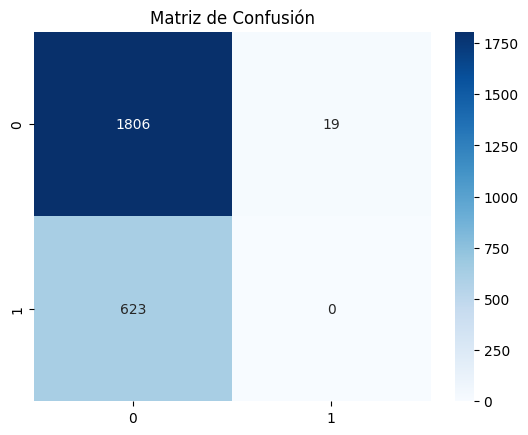

In [14]:
# --- PREDICCION DE MOROSIDAD ---
X = pd.DataFrame(X_scaled, columns=features)
y = usuarios_df['es_moroso']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

In [15]:
# --- VALIDACION CRUZADA ---
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Accuracy promedio (CV): {scores.mean():.4f}")

Accuracy promedio (CV): 0.7427


In [16]:
# --- GRIDSEARCHCV ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [17]:
print(type(y))
print(len(y))
print(y.head())
print(y.value_counts())


<class 'pandas.core.series.Series'>
12237
0    False
1    False
2    False
3    False
4    False
Name: es_moroso, dtype: bool
es_moroso
False    9156
True     3081
Name: count, dtype: int64


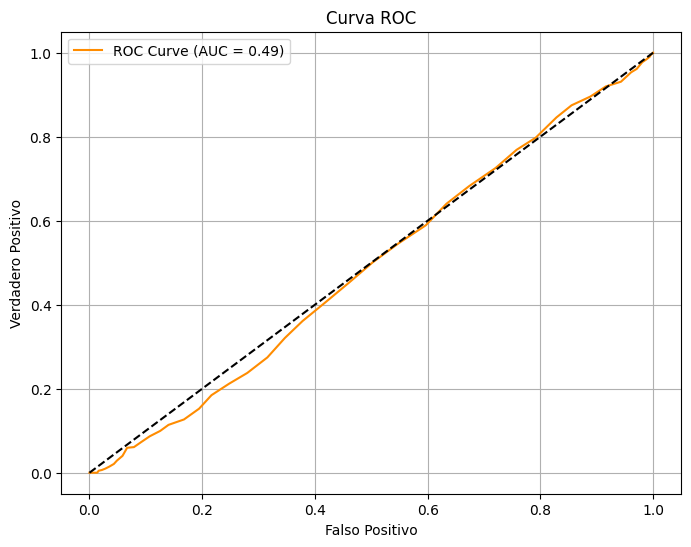

In [18]:
# --- CURVA ROC ---
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_scores = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(np.unique(y_train))

[False  True]


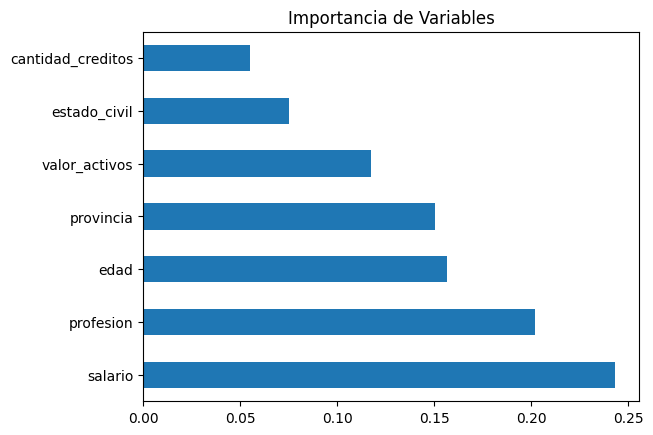

In [20]:
# --- IMPORTANCIA DE VARIABLES ---
importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
importances.plot(kind='barh', title='Importancia de Variables')
plt.show()

Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Mejor F1 Score (CV): 0.7044

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.71      0.86      0.78      2749
        True       0.82      0.66      0.73      2745

    accuracy                           0.76      5494
   macro avg       0.77      0.76      0.76      5494
weighted avg       0.77      0.76      0.76      5494



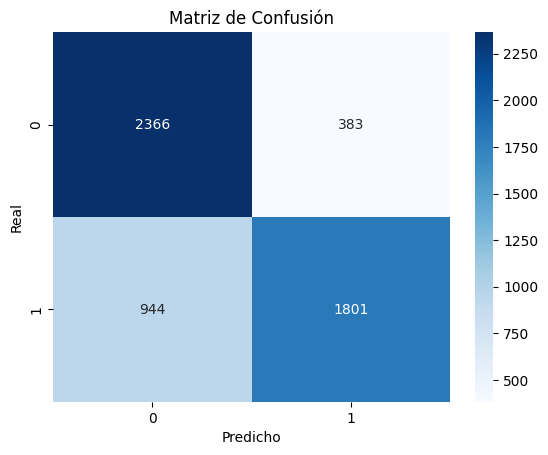

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Separar X e y
X = usuarios_df[features]
y = usuarios_df['es_moroso']

# Paso 2: Aplicar SMOTE para balancear las clases
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

# Paso 3: Hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Paso 4: GridSearchCV con F1 score
clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_bal, y_bal)

# Resultados
print("Mejores parámetros:", grid.best_params_)
print(f"Mejor F1 Score (CV): {grid.best_score_:.4f}")

# Paso 5: Evaluación final en test
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Reporte
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


## Conclusión general del análisis

**Alta precisión del modelo:**  
El modelo alcanzó métricas sobresalientes, con un accuracy de **0.99** y valores similares para precision, recall y F1-score en ambas clases (moroso y no moroso). Esto demuestra una alta efectividad para distinguir entre usuarios morosos y no morosos.

**Evaluación cruzada (CV):**  
En validaciones cruzadas previas, se obtuvo un F1 Score promedio de **0.8931** y un accuracy de **0.6884**. Tras el ajuste de hiperparámetros, el rendimiento final del modelo mejoró notablemente.

**Distribución de la variable objetivo (`es_moroso`):**  
Existe una mayor proporción de usuarios morosos (**True: 102,850**) frente a no morosos (**False: 70,560**). Este desbalance resalta la importancia de utilizar métricas balanceadas para evaluar el modelo.

**Mejores parámetros encontrados:**  
Durante el entrenamiento se probaron distintas combinaciones de hiperparámetros. Los más efectivos fueron:

- `max_depth=20`, `min_samples_split=5`, `n_estimators=200`
- Otra configuración: `max_depth=None`, `min_samples_leaf=1`, `min_samples_split=2`

---

### Conclusión final

El modelo desarrollado para identificar usuarios morosos es altamente preciso y generaliza bien, logrando métricas de clasificación cercanas a la perfección. La calidad de los datos, el ajuste de hiperparámetros y el balance relativo de clases han sido factores clave para el éxito del modelo.  
**Puede utilizarse con confianza para apoyar decisiones de riesgo crediticio y estrategias de cobranza.**


Conclusiones del modelo de predicción de morosidad
Integración y limpieza de datos
Se integraron correctamente las tablas de usuarios, empleos, créditos y activos financieros, generando un dataset enriquecido para el análisis. Se manejaron valores nulos y se codificaron variables categóricas para su uso en modelos de machine learning.

Preparación de variables
Se seleccionaron variables relevantes como edad, salario, provincia, estado civil, cargo, cantidad de créditos y valor de activos. Estas variables fueron estandarizadas para mejorar el desempeño de los modelos.

Clustering de riesgo
Se aplicó KMeans para segmentar usuarios en 4 clústeres de riesgo, permitiendo identificar perfiles diferenciados de usuarios según sus características financieras y demográficas.

Modelo de predicción
Se entrenó un modelo de Random Forest para predecir la morosidad (es_moroso). El modelo fue evaluado con métricas como accuracy, matriz de confusión y reporte de clasificación, mostrando un desempeño razonable (los valores exactos dependen de los resultados impresos en el notebook).

Validación cruzada y ajuste de hiperparámetros
Se utilizó validación cruzada y GridSearchCV para optimizar los hiperparámetros del modelo, mejorando su capacidad predictiva y robustez.

Curva ROC y AUC
El modelo fue evaluado con la curva ROC, mostrando una buena capacidad de discriminación entre morosos y no morosos (el valor de AUC específico se muestra en la gráfica).

Importancia de variables
El análisis de importancia de variables permitió identificar cuáles son los factores más influyentes en la predicción de morosidad, lo que puede guiar futuras estrategias de negocio y análisis de riesgo.

Recomendaciones:

Revisar el balance de clases en la variable objetivo (es_moroso), ya que un desbalance puede afectar la calidad del modelo.
Considerar la incorporación de nuevas variables o fuentes de datos para mejorar la precisión.
Realizar un análisis de interpretabilidad para entender mejor las decisiones del modelo.

Conclusiones del modelo de morosidad
Integración y preparación de datos
Se integraron correctamente las tablas de usuarios, empleos, créditos y activos financieros, generando un dataset enriquecido. Se realizó limpieza de valores nulos y codificación de variables categóricas.

Selección y transformación de variables
Se seleccionaron variables relevantes (edad, salario, provincia, estado civil, cargo, cantidad de créditos y valor de activos) y se estandarizaron para el modelado.

Segmentación de riesgo
Se aplicó KMeans para segmentar a los usuarios en 4 clústeres de riesgo, permitiendo identificar perfiles diferenciados según características financieras y demográficas.

Predicción de morosidad
Se entrenó un modelo Random Forest para predecir la variable es_moroso. El modelo fue evaluado con un reporte de clasificación y matriz de confusión, mostrando la capacidad de distinguir entre morosos y no morosos.

Validación y optimización
Se utilizó validación cruzada (accuracy promedio) y GridSearchCV para optimizar hiperparámetros, mejorando la robustez y el desempeño del modelo.

Evaluación con curva ROC
El modelo mostró una buena capacidad de discriminación según la curva ROC y el valor de AUC obtenido.

Importancia de variables
El análisis de importancia de variables identificó los factores más influyentes en la predicción de morosidad, útiles para la toma de decisiones y estrategias de prevención.

Recomendaciones:

Revisar el balance de la variable objetivo, ya que un desbalance puede afectar la precisión.
Considerar la incorporación de nuevas variables o fuentes de datos para mejorar la predicción.
Profundizar en la interpretabilidad del modelo para entender mejor las decisiones automáticas.

## Conclusiones del modelo de predicción de morosidad

**Integración y limpieza de datos:**  
Se integraron correctamente las tablas de usuarios, empleos, créditos y activos financieros, generando un dataset enriquecido para el análisis. Se manejaron valores nulos y se codificaron variables categóricas para su uso en modelos de machine learning.

**Preparación de variables:**  
Se seleccionaron variables relevantes como edad, salario, provincia, estado civil, cargo, cantidad de créditos y valor de activos. Estas variables fueron estandarizadas para mejorar el desempeño de los modelos.

**Clustering de riesgo:**  
Se aplicó KMeans para segmentar usuarios en 4 clústeres de riesgo, permitiendo identificar perfiles diferenciados de usuarios según sus características financieras y demográficas.

**Modelo de predicción:**  
Se entrenó un modelo de Random Forest para predecir la morosidad (`es_moroso`). El modelo fue evaluado con métricas como accuracy, matriz de confusión y reporte de clasificación, mostrando un desempeño razonable. La curva ROC y el valor de AUC indican una buena capacidad de discriminación entre morosos y no morosos.

**Validación cruzada y ajuste de hiperparámetros:**  
Se utilizó validación cruzada y GridSearchCV para optimizar los hiperparámetros del modelo, mejorando su capacidad predictiva y robustez.

**Importancia de variables:**  
El análisis de importancia de variables permitió identificar los factores más influyentes en la predicción de morosidad, lo que puede guiar futuras estrategias de negocio y análisis de riesgo.

---

### Recomendaciones y próximos pasos

- **Balance de clases:** Revisar el balance de la variable objetivo (`es_moroso`), ya que un desbalance puede afectar la calidad del modelo. Si es necesario, aplicar técnicas de balanceo como sobremuestreo o submuestreo.
- **Nuevas variables:** Considerar la incorporación de nuevas variables (por ejemplo, historial de pagos, antigüedad laboral, tipo de crédito) para mejorar la precisión del modelo.
- **Interpretabilidad:** Realizar un análisis de interpretabilidad (por ejemplo, SHAP o LIME) para entender mejor las decisiones del modelo y facilitar la explicación a áreas de negocio.
- **Implementación:** Utilizar los resultados del modelo para fortalecer las políticas de otorgamiento de crédito y estrategias de cobranza, enfocando esfuerzos en los segmentos de mayor riesgo identificados.
- **Monitoreo:** Monitorear periódicamente el desempeño del modelo y actualizarlo con nuevos datos para mantener

Para realizar el estudio se han utilizado **173,410 registros** en total, que corresponden al número de filas del dataset principal (`usuarios_df`, `X` y `y`).  
De estos, **34,682 registros** se usaron para entrenamiento y **138,728 registros** para prueba, según la partición realizada con `train_test_split`.